In [1]:
import pandas as pd

from acquirer.acquirer import *
from acquirer.acquirer import *
from model.model import *
from molecule_pool.molecule_pool import MoleculePool

import seaborn as sns
import matplotlib.pyplot as plt


BATCH_SIZE = 500
MAX_ITERATIONS = 6
NB_EXPERIMENTS = 5
k = 500
PATH = '../data/Enamine50k_rdkit2d.csv'

## Q1 & Q2 Implement the first brick, run it and output results

In [2]:

df = pd.read_csv(PATH).to_numpy()
df = df[:, 1:]

molecule_pool = MoleculePool(df)


models = [RandomForest({'n_estimators': 100,
                      'max_depth': 8,
                      }), 
          NN({'input_shape': 200, 'hidden_shape': 100, 'output_shape': 1}, epoch=100)]

acquisition_functions = [RandomSearch(batch_size=BATCH_SIZE),
                         Greedy(batch_size=BATCH_SIZE),
                        UBC(batch_size=BATCH_SIZE)]

df_results = pd.DataFrame(columns=["experiment",
                                "model",
                                "batch_size",
                                "acquisition_function"])

In [3]:
verbose = True

for i, model in enumerate(models):
    for j, acquisition_function in enumerate(acquisition_functions):
        
        print('Model used  :', model.name)
        print('Acquisition function used  :', acquisition_function.name)
        print('Batch Size  :', BATCH_SIZE)
        
        for experiment in range(NB_EXPERIMENTS):
            
            print('EXPERIMENT N°', experiment)
            ratio_found = []
            
            print('Initialize training set...')
            train_set, test_set = molecule_pool.initialize_batch(batch_size=BATCH_SIZE)
            
            # Get the name of top k molecule according to the docking score
            idx_best = molecule_pool.sort_idx_by_true_score()[:k]
            top_k_mol = set(molecule_pool.df[idx_best, 0])
            top_k_found = train_set.get_top_k(k, top_k_mol)
            
            if verbose:
                print("% of top {} molecules found :".format(k), (len(top_k_found)/k)*100, '%')
                print('='*50)

            if model.name == 'NN' and acquisition_function.name == 'UBC':
                print('Variance not yet implemented for NN')
                continue

            iteration = 0

            
            result = {'experiment':'Experiment_{}'.format(experiment),
                     'model': model.name,
                     'batch_size': BATCH_SIZE,
                     'acquisition_function' : acquisition_function.name,
                     len(train_set.df):(len(top_k_found)/k)*100}
            

            while iteration < MAX_ITERATIONS:
                if verbose:
                    print('ITERATION', iteration)
                    print('Train set shape : ', train_set.data.shape)
                    print('Training the model...')
                    
                model.train(train_set)

                score = model.predict(test_set, acquisition_function.require_var)

                most_promising_mol = acquisition_function.select_train_set(test_set)

                new_train_mol = np.concatenate((train_set.df[:, 0], most_promising_mol.df[:, 0]))

                train_set, test_set = molecule_pool.create_batch(new_train_mol)

                iteration += 1


                top_k_found = train_set.get_top_k(k, top_k_mol)

                if verbose:
                    print('Get top k molecules...')
                    print("% of top {} molecules found :".format(k), (len(top_k_found)/k)*100, '%')
                    print('='*50)
                
                
                result[len(train_set.df)] =  (len(top_k_found)/k)*100
                
            
            # add the results of the experiment
            df_results = df_results.append(result, ignore_index=True)
            
df_results.to_csv('../data/result.csv', index=False)

Model used  : RandomForestRegressor
Acquisition function used  : RandomSearch
Batch Size  : 500
EXPERIMENT N° 0
Initialize training set...
% of top 500 molecules found : 0.6 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 1.7999999999999998 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 2.6 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 4.0 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 5.4 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 5.800000000000001 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 6.6000000000000005 %
EXPERIMENT N° 1
Initialize trai

Get top k molecules...
% of top 500 molecules found : 59.8 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 66.60000000000001 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 71.8 %
EXPERIMENT N° 2
Initialize training set...
% of top 500 molecules found : 1.0 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 26.0 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 36.199999999999996 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 48.199999999999996 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 55.400000000000006 %
ITERATION 4
Train set shape :  (2500, 202)
Traini

2it [00:00, 15.63it/s]

Computing the variance...


100it [00:05, 18.19it/s]


Get top k molecules...
% of top 500 molecules found : 19.8 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...


2it [00:00, 15.16it/s]

Computing the variance...


100it [00:05, 18.27it/s]


Get top k molecules...
% of top 500 molecules found : 34.2 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...


2it [00:00, 15.63it/s]

Computing the variance...


100it [00:05, 18.68it/s]


Get top k molecules...
% of top 500 molecules found : 45.2 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...


2it [00:00, 14.93it/s]

Computing the variance...


100it [00:05, 18.41it/s]


Get top k molecules...
% of top 500 molecules found : 51.800000000000004 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...


2it [00:00, 15.76it/s]

Computing the variance...


100it [00:05, 19.07it/s]


Get top k molecules...
% of top 500 molecules found : 57.199999999999996 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...


2it [00:00, 16.14it/s]

Computing the variance...


100it [00:05, 18.85it/s]


Get top k molecules...
% of top 500 molecules found : 63.4 %
EXPERIMENT N° 1
Initialize training set...
% of top 500 molecules found : 0.8 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...


2it [00:00, 16.39it/s]

Computing the variance...


100it [00:05, 18.83it/s]


Get top k molecules...
% of top 500 molecules found : 14.799999999999999 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...


1it [00:00,  9.32it/s]

Computing the variance...


100it [00:05, 18.04it/s]


Get top k molecules...
% of top 500 molecules found : 29.2 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...


2it [00:00, 16.01it/s]

Computing the variance...


100it [00:05, 18.47it/s]


Get top k molecules...
% of top 500 molecules found : 40.8 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...


2it [00:00, 16.01it/s]

Computing the variance...


100it [00:05, 18.98it/s]


Get top k molecules...
% of top 500 molecules found : 50.0 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...


2it [00:00, 16.64it/s]

Computing the variance...


100it [00:04, 20.01it/s]


Get top k molecules...
% of top 500 molecules found : 56.39999999999999 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...


2it [00:00, 17.55it/s]

Computing the variance...


100it [00:05, 19.85it/s]


Get top k molecules...
% of top 500 molecules found : 58.4 %
EXPERIMENT N° 2
Initialize training set...
% of top 500 molecules found : 0.8 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...


2it [00:00, 15.16it/s]

Computing the variance...


100it [00:05, 17.82it/s]


Get top k molecules...
% of top 500 molecules found : 21.0 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...


2it [00:00, 15.16it/s]

Computing the variance...


100it [00:05, 18.04it/s]


Get top k molecules...
% of top 500 molecules found : 37.4 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...


2it [00:00, 15.51it/s]

Computing the variance...


100it [00:05, 18.29it/s]


Get top k molecules...
% of top 500 molecules found : 45.6 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...


2it [00:00, 14.19it/s]

Computing the variance...


100it [00:05, 18.82it/s]


Get top k molecules...
% of top 500 molecules found : 53.2 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...


2it [00:00, 16.14it/s]

Computing the variance...


100it [00:05, 18.93it/s]


Get top k molecules...
% of top 500 molecules found : 57.599999999999994 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...


2it [00:00, 16.68it/s]

Computing the variance...


100it [00:05, 18.63it/s]


Get top k molecules...
% of top 500 molecules found : 62.6 %
EXPERIMENT N° 3
Initialize training set...
% of top 500 molecules found : 0.8 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...


2it [00:00, 15.16it/s]

Computing the variance...


100it [00:05, 18.04it/s]


Get top k molecules...
% of top 500 molecules found : 21.4 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...


2it [00:00, 14.50it/s]

Computing the variance...


100it [00:05, 18.09it/s]


Get top k molecules...
% of top 500 molecules found : 36.8 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...


2it [00:00, 15.16it/s]

Computing the variance...


100it [00:05, 18.00it/s]


Get top k molecules...
% of top 500 molecules found : 45.6 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...


2it [00:00, 15.28it/s]

Computing the variance...


100it [00:05, 18.52it/s]


Get top k molecules...
% of top 500 molecules found : 49.4 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...


2it [00:00, 16.90it/s]

Computing the variance...


100it [00:05, 19.33it/s]


Get top k molecules...
% of top 500 molecules found : 56.39999999999999 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...


2it [00:00, 16.01it/s]

Computing the variance...


100it [00:05, 19.17it/s]


Get top k molecules...
% of top 500 molecules found : 61.8 %
EXPERIMENT N° 4
Initialize training set...
% of top 500 molecules found : 1.6 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...


2it [00:00, 15.23it/s]

Computing the variance...


100it [00:05, 18.90it/s]


Get top k molecules...
% of top 500 molecules found : 23.200000000000003 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...


2it [00:00, 15.88it/s]

Computing the variance...


100it [00:05, 18.82it/s]


Get top k molecules...
% of top 500 molecules found : 33.800000000000004 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...


2it [00:00, 16.98it/s]

Computing the variance...


100it [00:05, 19.13it/s]


Get top k molecules...
% of top 500 molecules found : 42.6 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...


2it [00:00, 15.05it/s]

Computing the variance...


100it [00:05, 18.51it/s]


Get top k molecules...
% of top 500 molecules found : 52.2 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...


2it [00:00, 15.88it/s]

Computing the variance...


100it [00:05, 18.81it/s]


Get top k molecules...
% of top 500 molecules found : 58.4 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...


2it [00:00, 15.76it/s]

Computing the variance...


100it [00:05, 18.81it/s]


Get top k molecules...
% of top 500 molecules found : 64.8 %
Model used  : NN
Acquisition function used  : RandomSearch
Batch Size  : 500
EXPERIMENT N° 0
Initialize training set...
% of top 500 molecules found : 2.0 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...


c:\users\antonin\miniconda3\lib\site-packages\torch\autograd\__init__.py:145: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


Get top k molecules...
% of top 500 molecules found : 2.8000000000000003 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 4.0 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 4.2 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 5.0 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 5.2 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 6.0 %
EXPERIMENT N° 1
Initialize training set...
% of top 500 molecules found : 0.6 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 1.7999999999999998 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
Get top k molecu

Get top k molecules...
% of top 500 molecules found : 73.4 %
EXPERIMENT N° 2
Initialize training set...
% of top 500 molecules found : 1.0 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 32.2 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 44.4 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 55.800000000000004 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 64.0 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 71.8 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 75.4 %
EXPERIMENT N° 3
Initialize training set...
% of top 500 molecules found : 0.6 %
ITERATION 

## Q3b Analysis of the results on different model choices

In [4]:
sns.set_theme()

result_per_model = df_results.groupby(["model","acquisition_function"]).mean()
result_per_model

500    1000   1500   2000   2500  \
model                 acquisition_function                                     
NN                    Greedy                0.92  30.80  46.48  55.76  62.96   
                      RandomSearch          1.32   2.28   3.52   4.44   5.36   
RandomForestRegressor Greedy                1.08  25.60  38.68  50.08  58.68   
                      RandomSearch          0.72   1.52   2.44   3.40   4.76   
                      UBC                   1.00  20.04  34.28  43.96  51.32   

                                             3000   3500  
model                 acquisition_function                
NN                    Greedy                69.28  73.32  
                      RandomSearch           6.04   6.92  
RandomForestRegressor Greedy                65.92  70.92  
                      RandomSearch           5.52   6.68  
                      UBC                   57.20  62.20

In [5]:
result_nn = result_per_model.loc['NN'].reset_index().T
result_nn.columns = result_nn.iloc[0]
result_nn = result_nn.drop(result_nn.index[0])
result_nn = result_nn.astype({"Greedy": float, "RandomSearch": float})

result_rf = result_per_model.loc['RandomForestRegressor'].reset_index().T
result_rf.columns = result_rf.iloc[0]
result_rf = result_rf.drop(result_rf.index[0])
result_rf = result_rf.astype({"Greedy": float, "RandomSearch": float, "UBC":float})

all_result = [result_rf, result_nn]

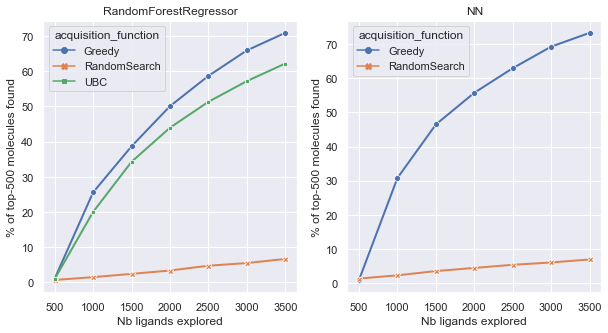

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

for i, ax in enumerate(axs):
    sns.lineplot(data=all_result[i], markers=True, dashes=False, linewidth=2, ax=ax)
    ax.set_xlabel('Nb ligands explored')
    ax.set_ylabel('% of top-500 molecules found')
    ax.set_title(df_results.model.unique()[i])

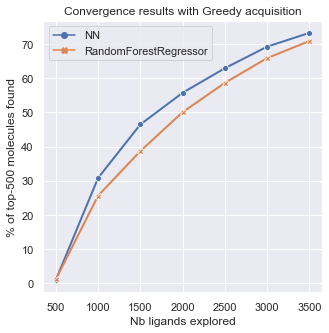

In [7]:
plt.figure(figsize=(5, 5))

ax = sns.lineplot(data=result_per_model.T.iloc[:, result_per_model.T.columns.get_level_values(1)=='Greedy'], 
                  markers=True, 
                  dashes=False, 
                  linewidth=2)

plot = ax.set_xlabel('Nb ligands explored')
plot = ax.set_ylabel('% of top-500 molecules found')
plot = ax.set_title('Convergence results with Greedy acquisition')

In [37]:
# Save % molecule found by the RandomSearch as the baseline
baseline = result_per_model.loc['NN','RandomSearch'].values[-1]

for idx in result_per_model.index:
    if idx[1] != 'RandomSearch':
        ef = result_per_model.loc[idx].values[-1] / baseline
        print(idx[0],'with acquisition function',idx[1],'has an enrichment factor of', round(ef, 2))

NN with acquisition function Greedy has an enrichment factor of 10.6
RandomForestRegressor with acquisition function Greedy has an enrichment factor of 10.25
RandomForestRegressor with acquisition function UBC has an enrichment factor of 8.99


In [39]:
result_per_model

500    1000   1500   2000   2500  \
model                 acquisition_function                                     
NN                    Greedy                0.92  30.80  46.48  55.76  62.96   
                      RandomSearch          1.32   2.28   3.52   4.44   5.36   
RandomForestRegressor Greedy                1.08  25.60  38.68  50.08  58.68   
                      RandomSearch          0.72   1.52   2.44   3.40   4.76   
                      UBC                   1.00  20.04  34.28  43.96  51.32   

                                             3000   3500  
model                 acquisition_function                
NN                    Greedy                69.28  73.32  
                      RandomSearch           6.04   6.92  
RandomForestRegressor Greedy                65.92  70.92  
                      RandomSearch           5.52   6.68  
                      UBC                   57.20  62.20